In [109]:
import pathlib
import tqdm
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.cm as cm
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [143]:
# NOTEBOOK SETUP.
# CHOSE OPTIONS, PATHS, DATE RANGES, ETC. HERE IN THIS CELL

# Options for what to calculate
# Calulations will be saved to pkl
# If False, will load in pkl files
######################################
calculate_metric_dictionary = False #
calculate_flow_categories = False   #
calculate_metric_matrix = False     #
######################################

val_start='10/01/1989'
val_end='09/30/1999'
date_range = pd.date_range(start=val_start, end=val_end)

# Specifics about the analysis to use. 
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
short_metric_names = ['NSE', 'Bias', 'Timing']
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total bias', 'Peak timing error']
use_metric_locs = [0,6,11]
# Plotting parameters for the metrics defined above.
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
display_colors_from_control = {'base_model':'PRGn', 'lagged_streamflow_both':'PRGn'} 
#Alternative color scheme: 'PuOr'
display_bounds_from_control = {'base_model':[(0.2,1), (-0.2,0.1), (0,1.6)], 
                               'lagged_streamflow_both':[(0.2,1), (-0.08,0.04), (0,1.6)]}

# local directory with all data
# not included in github
data_dir = "./data/"

In [44]:
if True: # Open the attributes set up to do regression
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0_Regression.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = data_dir+'camels_attributes_v2.0/camels_attributes_v2.0.csv'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')

# Catchment attributes and hydrologic signatures that are not useful
drop_these = ['high_prec_timing','root_depth_50',
              'root_depth_99','zero_q_freq','water_frac','organic_frac']
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

# These are bad for the regression analysis.
attributes = attributes.drop(drop_these, axis=1)
attributes.shape

(671, 45)

In [45]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [25]:
with open(data_dir+"ensemble_metrics.pkl", "rb") as fb:
    ensemble_metrics = pkl.load(fb)
with open(data_dir+"individual_run_metrics.pkl", "rb") as fb:
    individual_run_metrics = pkl.load(fb)
with open(data_dir+"observations.pkl", "rb") as fb:
    observations = pkl.load(fb)
with open(data_dir+"simulations.pkl", "rb") as fb:
    simulations = pkl.load(fb)

In [77]:
basin_list = observations.columns.values

In [90]:
np.array(ensemble_metrics['NSE', 'base_model'])

array([0.8835914484219056, 0.9039921851971319, 0.8844040955844171,
       0.8716929595649702, 0.7749084760404049, 0.7416955071649887,
       0.9018521177517314, 0.8935602515735619, 0.8926923882960256,
       0.8588761387423123, 0.8199097167948374, 0.8538508079724784,
       0.8113585107013407, 0.7740133112949183, 0.8453169994038818,
       0.8917492399102637, 0.8752108922354243, 0.8346910476406434,
       0.8403510513614487, 0.8371875942116058, 0.8462942207430215,
       0.7244448698008992, 0.8431006941730106, 0.8128366160503744,
       0.7522673909630322, 0.667630888324882, 0.8362287448357864,
       0.7391600159786984, 0.8056484779110854, 0.8041430607781912,
       0.8591388053117904, 0.8600182005461058, 0.8209528608408178,
       0.8553615685457119, 0.8565458799668152, 0.8633231522838867,
       0.8148275591607115, 0.8449732367573335, 0.7175651027916552,
       0.6570828894556258, 0.8645950001985008, 0.8414541276161349,
       0.8693623161285566, 0.6905270650816665, 0.73811056312700

In [32]:
# Probably do not need this because all the metrics are saved in ensemble_metrics
def nse(y, y_hat):
    idx = (~np.isnan(y)) & (~np.isnan(y_hat))
    return 1 - np.nansum((y[idx] - y_hat[idx])**2) / np.nansum((y[idx] - np.nanmean(y[idx]))**2)

In [61]:
# Testing metric saved vs calculated
print('calculated', nse(observations['01022500'], simulations['01022500', 'base_model']))
print('ensemble_metrics', ensemble_metrics.loc['01022500',['NSE', 'base_model']][0])
print('individual_run_metrics', individual_run_metrics.loc['01022500',['NSE', 'base_model']][0])

calculated 0.8835914484219056
ensemble_metrics 0.8835914484219056
individual_run_metrics 0.8760620877146721


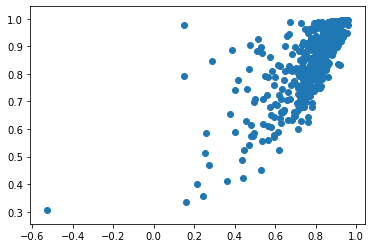

In [132]:
plt.scatter(ensemble_metrics['NSE', 'base_model'], ensemble_metrics['NSE', 'base_model_states'])

In [78]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [125]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    for m, metric in enumerate(use_metrics):
        count_improved = 0
        count_detriment = 0
        count_total = 0
        imet=use_metric_locs[m]
        for i, ival in enumerate(improvement[:,m]):
            if ensemble_metrics[metric, 'base_model'][i] < threshold:
                count_total += 1
                if ival > 0:
                    count_improved+= 1
                if ival < 0:
                    count_detriment+= 1
        if verbose:
            print(metric)
            print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                   count_improved/count_total))
            print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                      count_detriment/count_total))
        else:
            if metric == 'NSE':
                return count_improved/count_total

In [126]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    percent_improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    for m, metric in enumerate(use_metrics):
        imet=use_metric_locs[m]
        if optimal[m] == 1:
            improvement[:,m] = ensemble_metrics[metric, test] - \
                               ensemble_metrics[metric, control]
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metrics[metric, control])
        elif optimal[m] == 0:
            improvement[:,m] = np.abs(ensemble_metrics[metric,control]) - \
                                np.abs(ensemble_metrics[metric, test])
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metrics[metric, control])
    if percent:
        return percent_improvement
    else:
        return improvement

In [127]:
improvement = PERFORMANCE_IMPROVEMENTS('base_model', 'lagged_streamflow_both', percent=False)

In [139]:
def PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, percent=False):
    
    fig = plt.figure(figsize=(10, 9))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
        for b, basin in enumerate(basin_list):
            basin_color = im.to_rgba(improvement[b,m])
            ax1.scatter(ensemble_metrics[metric, control][b], 
                        ensemble_metrics[metric, test][b],
                        s=5,
                        color=im.to_rgba(improvement[b,m]))
        ax1.set_xlabel(control)
        ax1.set_ylabel(test)
        ax1.set_xlim(display_bounds_from_control[control][m])
        ax1.set_ylim(display_bounds_from_control[test][m])
        ax1.grid()

    plt.tight_layout()

NSE
Number of improved basins = 489, 0.92%
Number of detrimented basins = 42, 0.08%
Beta-NSE
Number of improved basins = 465, 0.88%
Number of detrimented basins = 66, 0.12%
Peak-Timing
Number of improved basins = 81, 0.16%
Number of detrimented basins = 331, 0.67%


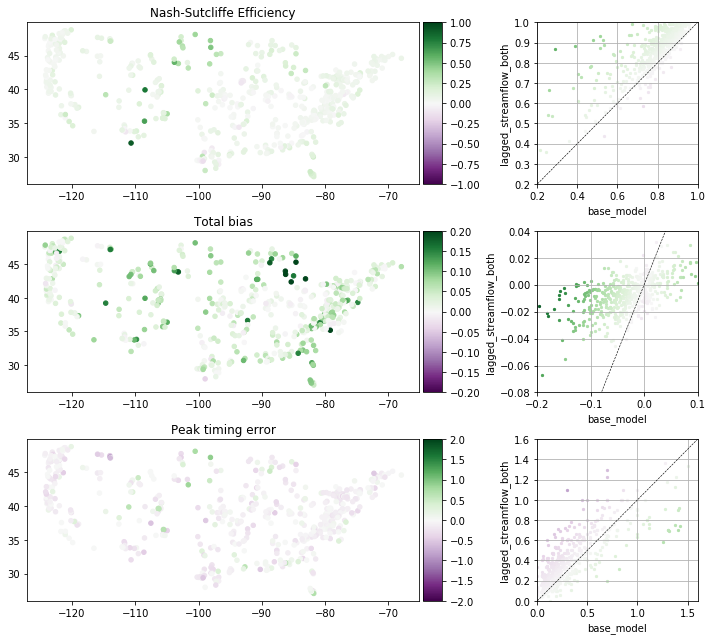

In [144]:
control='base_model'
test='lagged_streamflow_both'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)